<a href="https://colab.research.google.com/github/Zhou-spec/OTC_Marketing_Making/blob/main/mlp_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Net(nn.Module):
    def __init__(self, input_size, output_size, final_act):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 2096)
        self.fc2 = nn.Linear(2096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 64)
        self.fc5 = nn.Linear(64, output_size)
        
        # define the activation function
        self.relu = nn.ReLU()
        self.final_act = final_act
    

    def forward(self, t, S, q):
        # define the forward pass
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = torch.tensor([t, S, q], device = device)
        x = self.fc1(x)
        x = self.relu(x)
        # add 5 more layers
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.final_act(x)

        return x

def Stock_Prices_Simulation(T, dt, sigma, S0):
    # T: the total time needed
    # dt: the time interval
    # sigma: the volatility
    # S0: the initial stock price
    # the output is the simulated stock prices in torch tensor
    
    # let S be on the same device as S0
    N = int(T / dt)
    device = S0.device
    S = torch.zeros(N, device = device)
    S[0] = S0
    for i in range(1, N):
        S[i] = S[i - 1] + sigma * (torch.sqrt(torch.tensor([dt])) * torch.randn(1)).to(device)

    return S


def Market_Order_Generator(bid_vector, ask_vector, A, B, dt):
    # bid_vector: the bid price vector, torch tensor of size N
    # ask_vector: the ask price vector, torch tensor of size N
    # dt: the time interval
    # In this project, we assume that MO intensity lambda = A - B * epsilon

    N = len(A)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buy_orders = torch.zeros(N, device = device)
    sell_orders = torch.zeros(N, device = device)
    
    bid_intensity = A - B * bid_vector
    ask_intensity = A - B * ask_vector
    buy_orders = torch.distributions.poisson.Poisson(bid_intensity * dt).sample()
    sell_orders = torch.distributions.poisson.Poisson(ask_intensity * dt).sample()

    return buy_orders, sell_orders

def initial_Gaussian_Policy(t, S, q, net, A, B, Q, z, delta, gamma):
    N = len(A)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    bid_vector = torch.zeros(N, device = device)
    ask_vector = torch.zeros(N, device = device)

    mean = net.forward(t, S, q)
    bid_mean = mean[:int(len(mean) / 2)]
    ask_mean = mean[int(len(mean) / 2):]
    covariance_matrix = torch.diag(gamma / (2 * z * B))
    covariance_matrix = covariance_matrix.to(device)
    bid_vector = torch.distributions.multivariate_normal.MultivariateNormal(bid_mean, covariance_matrix).sample()
    ask_vector = torch.distributions.multivariate_normal.MultivariateNormal(ask_mean, covariance_matrix).sample()

    return bid_vector, ask_vector


def initial_Train_Data_Simulation(T, dt, sigma, S0, A, B, Q, z, delta, gamma, net):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    S = Stock_Prices_Simulation(T, dt, sigma, S0)
    buy_orders = torch.zeros(N, len(A))
    sell_orders = torch.zeros(N, len(A))
    buy_orders = buy_orders.to(device)
    sell_orders = sell_orders.to(device)
    q = torch.zeros(N, device = device)
    t = torch.zeros(N, device = device)
    bid_vectors = torch.zeros(N, len(A))
    ask_vectors = torch.zeros(N, len(A))
    bid_vectors = bid_vectors.to(device)
    ask_vectors = ask_vectors.to(device)
    for i in range(N - 1):
        bid_vector, ask_vector = initial_Gaussian_Policy(t[i], S[i], q[i], net, A, B, Q, z, delta, gamma)
        bid_vectors[i] = bid_vector
        ask_vectors[i] = ask_vector
        buy_orders[i], sell_orders[i] = Market_Order_Generator(bid_vector, ask_vector, A, B, dt)
        for j in range(len(A)):
            q[i + 1] += (buy_orders[i][j] - sell_orders[i][j]) * z[j]
        q[i + 1] += q[i]
        t[i + 1] = t[i] + dt
        
    return S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors


def value_function_loss(net, S, q, t, dt):
    N = len(q)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss = torch.zeros(N, device = device)
    for i in range(N - 1):
        loss[i] = (net.forward(t[i + 1], S[i + 1], q[i + 1]) - net.forward(t[i], S[i], q[i])) / dt
    return loss

def inventory_loss(net, S, q, t, dt, buy_orders, sell_orders, z, delta, Q, A, B):
    N = len(q)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss = torch.zeros(N, device = device)
    for i in range(N):
        for k in range(len(A)):
            loss[i] = loss[i] + (buy_orders[i][k] - sell_orders[i][k]) * (z[k] * S[i]) - delta * q[i] * q[i]
            loss[i] = loss[i] +  (A[k] / (2 * B[k]) - (net.forward(t[i], S[i], q[i] + z[k]) - net.forward(t[i], S[i], q[i]) + z[k] * S[i]) / (2 * z[k])) * buy_orders[i][k]
            loss[i] = loss[i] + (A[k] / (2 * B[k]) - (net.forward(t[i], S[i], q[i] - z[k]) - net.forward(t[i], S[i], q[i]) - z[k] * S[i]) / (2 * z[k])) * sell_orders[i][k]
    return loss

def total_loss(net, S, q, t, dt, buy_orders, sell_orders, z, delta, Q, A, B, gamma):
    N = len(S)
    K = len(A)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss = torch.zeros(N, device = device)
    loss1 = value_function_loss(net, S, q, t, dt)
    loss2 = inventory_loss(net, S, q, t, dt, buy_orders, sell_orders, z, delta, Q, A, B)
    loss = loss1 + loss2 - gamma * ((K * 1.7981798683) + torch.sum(gamma / (2 * z * B)))
    
    scalar_loss = 0.5 * torch.sum(loss[:-1] ** 2) * dt * dt
    return scalar_loss

T = torch.tensor([1])
dt = torch.tensor([0.01])
S0 = torch.tensor([1])
q = torch.tensor([0])
A = torch.tensor([20, 18, 15, 12, 10, 8])
B = torch.tensor([1, 1, 1, 1, 1, 1])
Q = torch.tensor([300]) # this quantity doesn't matter since I changed the reward function
z = torch.tensor([10, 20, 30, 40, 50, 60])
delta = torch.tensor([0.01]) # this quantity also doesn't matter
gamma = torch.tensor([0.01])
sigma = torch.tensor([0.05])

# use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T = T.to(device)
dt = dt.to(device)
S0 = S0.to(device)
q = q.to(device)
A = A.to(device)
B = B.to(device)
Q = Q.to(device)
z = z.to(device)
delta = delta.to(device)
gamma = gamma.to(device)
sigma = sigma.to(device)

policy_net = Net(3, 12, nn.Sigmoid()).to(device)
value_net = Net(3, 1, nn.Identity()).to(device)
optimizer = torch.optim.Adam(value_net.parameters(), lr = 0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma = 0.95)
loss_policy = []
data = []

for _ in range(50):
  S, buy_orders, sell_orders, q, t, bid_vector, ask_vectors = initial_Train_Data_Simulation(T, dt, sigma, S0, A, B, Q, z, delta, gamma, policy_net)
  data.append([S, buy_orders, sell_orders, q, t, bid_vector, ask_vectors])



In [7]:
for epoch in range(50):
    loss = 0
    holder = epoch % 5
    for batch in range(10):
        S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = data[holder * 10 + batch]
        loss += total_loss(value_net, S, q, t, dt, buy_orders, sell_orders, z, delta, Q, A, B, gamma)
    loss_policy.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    print('epoch: ', epoch, 'loss: ', loss.item() / 20)



Epoch-0 lr: 0.02
epoch:  0 loss:  177072.175
Epoch-1 lr: 0.02
epoch:  1 loss:  470925414.4
Epoch-2 lr: 0.02
epoch:  2 loss:  18453046.4
Epoch-3 lr: 0.02
epoch:  3 loss:  10257367.2
Epoch-4 lr: 0.019
epoch:  4 loss:  8196919.2
Epoch-5 lr: 0.019
epoch:  5 loss:  4477575.6
Epoch-6 lr: 0.019
epoch:  6 loss:  1865575.2
Epoch-7 lr: 0.019
epoch:  7 loss:  1693803.6
Epoch-8 lr: 0.019
epoch:  8 loss:  4644280.8
Epoch-9 lr: 0.01805
epoch:  9 loss:  1589639.0
Epoch-10 lr: 0.01805
epoch:  10 loss:  321143.275
Epoch-11 lr: 0.01805
epoch:  11 loss:  4807704.8
Epoch-12 lr: 0.01805
epoch:  12 loss:  11114896.8
Epoch-13 lr: 0.01805
epoch:  13 loss:  296721.525
Epoch-14 lr: 0.0171475
epoch:  14 loss:  9540920.8
Epoch-15 lr: 0.0171475
epoch:  15 loss:  1113328.2
Epoch-16 lr: 0.0171475
epoch:  16 loss:  5112730.4
Epoch-17 lr: 0.0171475
epoch:  17 loss:  64488.3375
Epoch-18 lr: 0.0171475
epoch:  18 loss:  3215803.8
Epoch-19 lr: 0.016290125
epoch:  19 loss:  1948420.4
Epoch-20 lr: 0.016290125
epoch:  20 los

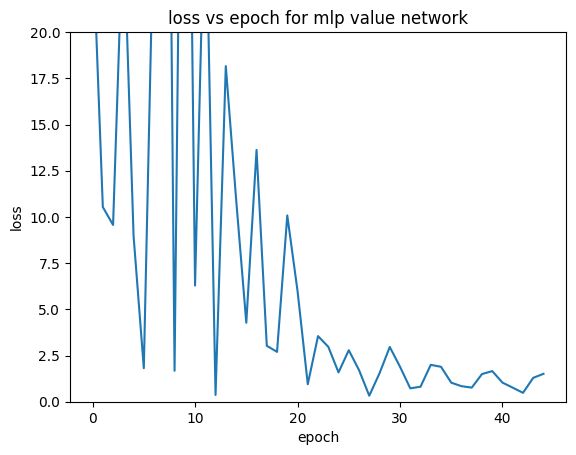

In [10]:
import matplotlib.pyplot as plt

loss = [i / loss_policy[0] for i in loss_policy]
plt.figure()
plt.plot(loss[5:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch for mlp value network')
plt.ylim(0, 20)
plt.savefig('mlp_loss.png')
plt.show()


In [11]:
torch.save(policy_net.state_dict(), 'policy_net_mlp.pt')
torch.save(value_net.state_dict(), 'value_net_mlp.pt')

import numpy as np
l = np.array(loss_policy)
np.save('loss_policy_mlp.npy', l)